In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
from dataset.data import *
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class StockDataset(Dataset):
    def __init__(self, stock_data, sequence_length=30):
        """
        Args:
            stock_data (list): List of dictionaries containing 'history' and 'target'.
            sequence_length (int): Number of historical days used as input.
        """
        self.data = stock_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]['history'], dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(self.data[idx]['target'], dtype=torch.float32)
        return x, y

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int, dropout: float = 0.2):
        """
        LSTM-based model for time series prediction.

        Args:
            input_size (int): Number of features per time step.
            hidden_size (int): Number of hidden units in LSTM layers.
            num_layers (int): Number of LSTM layers.
            output_size (int): Number of output features.
            dropout (float): Dropout rate.
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state
        return out

In [5]:
def eval_lstm(model, test_loader, device):
    """
    Evaluate the LSTM model.
    """
    model.eval()  # Set model to evaluation mode
    total_mape = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            out = model(inputs)
            mape = torch.mean(torch.abs((targets - out.squeeze()) / (targets + 1e-7)))
            total_mape += mape.item()

    return total_mape / len(test_loader)

In [6]:
def train_lstm(model, optimizer, train_loader, test_loader, num_epochs, device):
    """
    Train the LSTM model with proper mode management.
    """
    model.train()  # Ensure the model starts in training mode
    average_train_loss = []
    average_test_mape = []

    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0

        # Training loop
        model.train()  # Set model to training mode
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            out = model(inputs)

            loss = F.mse_loss(out.squeeze(), targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        average_loss = total_train_loss / len(train_loader)
        average_train_loss.append(average_loss)

        # Evaluation loop
        test_mape = eval_lstm(model, test_loader, device)
        average_test_mape.append(test_mape)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}, Train Loss: {average_loss:.4f}, Val MAPE: {test_mape:.4f}")

    return average_train_loss, average_test_mape

In [7]:
def prepare_stock_data(dataset, sequence_length=30):
    """
    Prepares the stock data for LSTM training directly from the dataset.

    Args:
        dataset (NASDAQDataset): The initialized and processed NASDAQDataset object.
        sequence_length (int): Number of historical days to use as input.

    Returns:
        list: A list of dictionaries with 'history' and 'target'.
    """
    stock_data = []

    for stock in dataset.filtered_stock_list:
        stock_df = dataset.data[stock]

        for i in range(sequence_length, len(stock_df) - 1):  # Ensure enough data for history and target
            history = stock_df['Adj Close'].iloc[i - sequence_length:i].values
            target = stock_df['Adj Close'].iloc[i + 1]
            stock_data.append({
                "history": history.tolist(),
                "target": target
            })

    return stock_data

In [ ]:
import matplotlib.pyplot as plt

def main():
    # Initialize dataset
    stocks_path = "dataset\\dataset\\stocks"
    meta_path = "dataset\\dataset\\symbols_valid_meta.csv"
    nasdaq_100_path = "dataset\\LSTMStock.csv"
    start_date = "2014-01-01"

    dataset = NASDAQDataset(stocks_path, meta_path, nasdaq_100_path, start_date)

    dataset.read_data()

    # Prepare stock data for LSTM
    sequence_length = 50
    stock_data = prepare_stock_data(dataset, sequence_length)

    # Normalize stock data
    scaler = MinMaxScaler(feature_range=(0, 1))
    for stock in dataset.filtered_stock_list:
        dataset.data[stock]['Adj Close'] = scaler.fit_transform(dataset.data[stock]['Adj Close'].values.reshape(-1, 1))

    # Split into train and test sets
    train_size = 1000
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]

    train_dataset = StockDataset(train_data, sequence_length)
    test_dataset = StockDataset(test_data, sequence_length)

    print(f"Training samples: {len(train_data)}")
    print(f"Testing samples: {len(test_data)}")

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize LSTM model
    input_size = 1  # Historical closing prices
    hidden_size = 128
    num_layers = 3
    output_size = 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train the model
    epochs = 500
    average_train_loss, average_test_mape = train_lstm(
        model, optimizer, train_loader, test_loader, epochs, device
    )

    # Save the model
    model_save_path = "lstm_stock_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}.")

    # Plot validation MAPE
    plt.title('Validation MAPE')
    plt.plot(average_test_mape, label='LSTM')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.show()

    # Print final metrics
    print(f"Final Train Loss: {average_train_loss[-1]:.4f}, Final Test MAPE: {average_test_mape[-1]:.4f}")

100%|██████████| 1/1 [00:00<00:00, 64.37it/s]
c:\Users\wyatt\.conda\envs\Python38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'MSFT': {Timestamp('2018-12-26 00:00:00'), Timestamp('2016-09-12 00:00:00'), Timestamp('2014-08-27 00:00:00'), Timestamp('2016-04-06 00:00:00'), Timestamp('2017-08-04 00:00:00'), Timestamp('2014-06-27 00:00:00'), Timestamp('2014-10-22 00:00:00'), Timestamp('2016-09-27 00:00:00'), Timestamp('2019-06-21 00:00:00'), Timestamp('2017-08-07 00:00:00'), Timestamp('2020-01-28 00:00:00'), Timestamp('2015-04-17 00:00:00'), Timestamp('2019-06-18 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2017-06-27 00:00:00'), Timestamp('2016-08-26 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2016-09-29 00:00:00'), Timestamp('2018-12-24 00:00:00'), Timestamp('2015-08-26 00:00:00'), Timestamp('2014-03-31 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2015-12-08 00:00:00'), Timestamp('2019-09-06 00:00:00'), Timestamp('2019-03-18 00:00:00'), Timestamp('2019-04-22 00:00:00'), Timestamp('2019-03-12 00:00:00'), Timestamp('2015-07-06 00:00:00'), Timestamp('2019-12-23 00:00:00'), Time

  0%|          | 1/500 [00:00<03:19,  2.50it/s]

Epoch 000, Train Loss: 2883.2306, Val MAPE: 0.9716


  2%|▏         | 11/500 [00:02<01:57,  4.18it/s]

Epoch 010, Train Loss: 1683.8368, Val MAPE: 0.8760


  4%|▍         | 21/500 [00:05<01:55,  4.15it/s]

Epoch 020, Train Loss: 1175.6958, Val MAPE: 0.8141


  6%|▌         | 31/500 [00:07<01:56,  4.04it/s]

Epoch 030, Train Loss: 815.1348, Val MAPE: 0.7588


  8%|▊         | 41/500 [00:09<01:47,  4.28it/s]

Epoch 040, Train Loss: 554.1352, Val MAPE: 0.7090


 10%|█         | 51/500 [00:12<01:45,  4.28it/s]

Epoch 050, Train Loss: 388.5993, Val MAPE: 0.6651


 12%|█▏        | 61/500 [00:14<01:38,  4.47it/s]

Epoch 060, Train Loss: 289.3642, Val MAPE: 0.6278


 14%|█▍        | 71/500 [00:16<01:35,  4.50it/s]

Epoch 070, Train Loss: 237.2702, Val MAPE: 0.5980


 16%|█▌        | 81/500 [00:19<01:33,  4.49it/s]

Epoch 080, Train Loss: 149.9638, Val MAPE: 0.5603


 18%|█▊        | 91/500 [00:21<01:32,  4.43it/s]

Epoch 090, Train Loss: 101.3582, Val MAPE: 0.5243


 20%|██        | 101/500 [00:23<01:31,  4.34it/s]

Epoch 100, Train Loss: 70.7998, Val MAPE: 0.4910


 22%|██▏       | 111/500 [00:25<01:28,  4.40it/s]

Epoch 110, Train Loss: 47.9346, Val MAPE: 0.4602


 24%|██▍       | 121/500 [00:28<01:27,  4.35it/s]

Epoch 120, Train Loss: 32.0633, Val MAPE: 0.4314


 26%|██▌       | 131/500 [00:30<01:23,  4.43it/s]

Epoch 130, Train Loss: 22.0343, Val MAPE: 0.4053


 28%|██▊       | 141/500 [00:32<01:20,  4.48it/s]

Epoch 140, Train Loss: 14.7135, Val MAPE: 0.3804


 30%|███       | 151/500 [00:34<01:17,  4.51it/s]

Epoch 150, Train Loss: 9.8962, Val MAPE: 0.3566


 32%|███▏      | 161/500 [00:37<01:15,  4.50it/s]

Epoch 160, Train Loss: 6.2664, Val MAPE: 0.3352


 34%|███▍      | 171/500 [00:39<01:14,  4.44it/s]

Epoch 170, Train Loss: 4.0331, Val MAPE: 0.3161


 36%|███▌      | 181/500 [00:41<01:12,  4.42it/s]

Epoch 180, Train Loss: 3.4159, Val MAPE: 0.3013


 38%|███▊      | 191/500 [00:43<01:09,  4.42it/s]

Epoch 190, Train Loss: 2.7026, Val MAPE: 0.2899


 40%|████      | 201/500 [00:46<01:09,  4.31it/s]

Epoch 200, Train Loss: 1.9836, Val MAPE: 0.2782


 42%|████▏     | 211/500 [00:48<01:07,  4.28it/s]

Epoch 210, Train Loss: 1.8263, Val MAPE: 0.2692


 44%|████▍     | 221/500 [00:50<01:04,  4.34it/s]

Epoch 220, Train Loss: 1.5385, Val MAPE: 0.2622


 46%|████▌     | 231/500 [00:53<01:01,  4.36it/s]

Epoch 230, Train Loss: 1.6926, Val MAPE: 0.2575


 48%|████▊     | 241/500 [00:55<00:59,  4.37it/s]

Epoch 240, Train Loss: 1.4778, Val MAPE: 0.2538


 50%|█████     | 251/500 [00:57<00:56,  4.44it/s]

Epoch 250, Train Loss: 1.3423, Val MAPE: 0.2515


 52%|█████▏    | 261/500 [01:00<00:53,  4.45it/s]

Epoch 260, Train Loss: 1.1925, Val MAPE: 0.2496


 54%|█████▍    | 271/500 [01:02<00:50,  4.53it/s]

Epoch 270, Train Loss: 1.2321, Val MAPE: 0.2486


 56%|█████▌    | 281/500 [01:04<00:48,  4.51it/s]

Epoch 280, Train Loss: 1.2603, Val MAPE: 0.2477


 58%|█████▊    | 291/500 [01:06<00:46,  4.47it/s]

Epoch 290, Train Loss: 1.4515, Val MAPE: 0.2473


 60%|██████    | 301/500 [01:08<00:45,  4.40it/s]

Epoch 300, Train Loss: 1.2906, Val MAPE: 0.2466


 62%|██████▏   | 311/500 [01:11<00:43,  4.34it/s]

Epoch 310, Train Loss: 1.2816, Val MAPE: 0.2464


 64%|██████▍   | 321/500 [01:13<00:41,  4.34it/s]

Epoch 320, Train Loss: 1.1897, Val MAPE: 0.2465


 66%|██████▌   | 331/500 [01:15<00:38,  4.42it/s]

Epoch 330, Train Loss: 1.2248, Val MAPE: 0.2466


 68%|██████▊   | 341/500 [01:18<00:35,  4.44it/s]

Epoch 340, Train Loss: 1.2274, Val MAPE: 0.2464


 70%|███████   | 351/500 [01:20<00:33,  4.41it/s]

Epoch 350, Train Loss: 1.2347, Val MAPE: 0.2458


 72%|███████▏  | 361/500 [01:22<00:31,  4.47it/s]

Epoch 360, Train Loss: 1.3024, Val MAPE: 0.2460


 74%|███████▍  | 371/500 [01:24<00:29,  4.41it/s]

Epoch 370, Train Loss: 1.2525, Val MAPE: 0.2458


 76%|███████▌  | 381/500 [01:27<00:26,  4.44it/s]

Epoch 380, Train Loss: 1.2281, Val MAPE: 0.2460


 78%|███████▊  | 391/500 [01:29<00:24,  4.47it/s]

Epoch 390, Train Loss: 1.1357, Val MAPE: 0.2458


 80%|████████  | 401/500 [01:31<00:22,  4.47it/s]

Epoch 400, Train Loss: 1.1912, Val MAPE: 0.2454


 82%|████████▏ | 411/500 [01:33<00:19,  4.47it/s]

Epoch 410, Train Loss: 1.2698, Val MAPE: 0.2454


 84%|████████▍ | 421/500 [01:36<00:17,  4.46it/s]

Epoch 420, Train Loss: 1.0691, Val MAPE: 0.2457


 86%|████████▌ | 431/500 [01:38<00:15,  4.39it/s]

Epoch 430, Train Loss: 1.1846, Val MAPE: 0.2460


 88%|████████▊ | 441/500 [01:40<00:13,  4.37it/s]

Epoch 440, Train Loss: 1.0940, Val MAPE: 0.2453


 90%|█████████ | 451/500 [01:43<00:11,  4.41it/s]

Epoch 450, Train Loss: 1.1425, Val MAPE: 0.2453


 92%|█████████▏| 461/500 [01:45<00:09,  4.30it/s]

Epoch 460, Train Loss: 1.0463, Val MAPE: 0.2454


 94%|█████████▍| 471/500 [01:47<00:06,  4.34it/s]

Epoch 470, Train Loss: 1.0235, Val MAPE: 0.2454


 96%|█████████▌| 481/500 [01:49<00:04,  4.45it/s]

Epoch 480, Train Loss: 1.1499, Val MAPE: 0.2454


 98%|█████████▊| 491/500 [01:52<00:01,  4.53it/s]

Epoch 490, Train Loss: 1.1037, Val MAPE: 0.2451


100%|██████████| 500/500 [01:54<00:00,  4.38it/s]

Model saved at lstm_stock_model.pth.


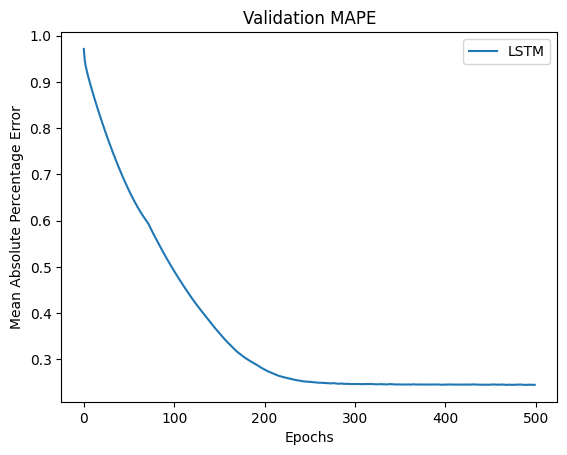

Final Train Loss: 1.0075, Final Test MAPE: 0.2451


In [11]:
main()